In [1]:
import numpy as np
import pandas as pd 
import pickle
import matplotlib.pyplot as plt
import copy 
from ucimlrepo import fetch_ucirepo 

import torch
import torch.nn as nn
import torch.optim as optim
from hyperopt import fmin, tpe, hp, Trials
from hyperopt.pyll.base import scope

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, matthews_corrcoef
from sklearn.model_selection import train_test_split

from significance_tests import compare_models, perform_t_tests
from ltn_imp.automation.knowledge_base import KnowledgeBase

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import random 
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Prepare Dataset

In [4]:
data = pd.read_csv("datasets/pima_indians_imputed.csv", index_col=0).astype(np.float32)
data["DiabetesPedigreeFunction"] =  data["DiabetesPedigreeFunction"] * 100
data["Pregnancies"] = data["Pregnancies"] * 10

In [5]:
def prepare_datasets(data, random_seed=42):    
    X = data.drop("Outcome", axis=1)  # Features
    y = data["Outcome"]  # Labels

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=random_seed, stratify=y)    
    X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=random_seed, stratify=y_train)

    train_data = pd.concat([X_train, y_train], axis=1)
    test_data = pd.concat([X_test, y_test], axis=1)
    val_data = pd.concat([X_val, y_val], axis=1)
    train_data_ = pd.concat([X_train_, y_train_], axis=1)

    train_data_.to_csv("datasets/train.csv", index=False)
    test_data.to_csv("datasets/test.csv", index=False)
    val_data.to_csv("datasets/val.csv", index=False)

    return train_data, test_data

In [6]:
train, test = prepare_datasets(data)
print(train.shape)
print(test.shape)

(384, 9)
(384, 9)


In [7]:
data.value_counts("Outcome")

Outcome
0.0    500
1.0    268
Name: count, dtype: int64

# Best Hyper-Parameters

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

def find_best_models(X,y):
    param_grid = {

        'KNN': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors': [3, 5, 7],
                'weights': ['uniform', 'distance'],
                'p': [1, 2]
            }
        },

        'DT': {
            'model': DecisionTreeClassifier(),
            'params': {
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'criterion': ['gini', 'entropy']
            }
        },

        'RF': {
            'model': RandomForestClassifier(),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5],
                'criterion': ['gini', 'entropy']
            }
        },
        
        'LR': {
            'model': LogisticRegression(max_iter=1000),
            'params': {
                'C': [0.1, 1, 10],
                'solver': ['lbfgs', 'liblinear']
            }
        }
    }

    best_models = {}
    for name, model_info in param_grid.items():
        grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=5, n_jobs=-1)
        grid_search.fit(X, y)
        best_models[name] = grid_search.best_estimator_

    models = []
    for name, model in best_models.items():
        if name == 'LR':
            models.append(LogisticRegression(**model.get_params()))
        elif name == 'KNN':
            models.append(KNeighborsClassifier(**model.get_params()))
        elif name == 'DT':
            models.append(DecisionTreeClassifier(**model.get_params()))
        elif name == 'RF':
            models.append(RandomForestClassifier(**model.get_params()))

    return models

# Train and Evaluate Models

In [9]:
kb = KnowledgeBase("config.yaml")
models = find_best_models(train.drop("Outcome", axis=1), train["Outcome"])
models.append(kb.predicates["Diabetic"])

Using device: cpu


In [10]:
model_names = ['KNN',
 'Decision Tree',
 'Random Forest',
 'Logistic Regression',
 'MLP',
 'Logic Tensor Network']

In [11]:
columns = train.columns[:-1]
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "MCC"]

## This section includes all methods needed to train and evalute all models

In [12]:
device = torch.device("cpu")

def predict(model, x):

    if hasattr(model, 'predict'):
        if isinstance(x, torch.Tensor):
            x = x.cpu().numpy()
        preds = model.predict(x)
        return torch.tensor(preds, dtype=torch.float32)
    
    model.eval() 

    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32)
    elif x.dtype != torch.float32:
        x = x.float()

    with torch.no_grad():  
        probs = model(x)
        preds = (probs > 0.5).float()

    return preds

def evaluate_model(loader, model, device):
    all_true_labels = []
    all_predicted_labels = []
    
    with torch.no_grad():  # Disable gradient computation
        for data, labels in loader:
            # Ensure data and labels are the correct dtype
            if not isinstance(data, torch.Tensor):
                data = torch.tensor(data, dtype=torch.float32)
            elif data.dtype != torch.float32:
                data = data.float()
            
            if not isinstance(labels, torch.Tensor):
                labels = torch.tensor(labels, dtype=torch.float32)
            elif labels.dtype != torch.float32:
                labels = labels.float()
            
            # Get predictions
            preds = predict(model, data)

            # Squeeze predictions and labels to remove dimensions of size 1
            predicted_labels = preds.squeeze()
            true_labels = labels.squeeze()

            # Ensure the shapes match before comparison
            if predicted_labels.shape != true_labels.shape:
                true_labels = true_labels.view_as(predicted_labels)
            
            # Collect all predictions and true labels for MCC
            all_true_labels.extend(true_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    true_labels = np.array(all_true_labels)
    predicted_labels = np.array(all_predicted_labels)
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, zero_division=0)  # zero_division=0 handles the division by zero case
    recall = recall_score(true_labels, predicted_labels, zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, zero_division=0)
    balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
    mcc = matthews_corrcoef(true_labels, predicted_labels)

    try:
        model.train()
    except:
        ""

    return accuracy, precision, recall, f1, balanced_accuracy, mcc

def evaluate_sklearn_model(dataset, model):
    # Assuming the last column is the label
    data = dataset.iloc[:, :-1]  # All columns except the last one are features
    true_labels = dataset.iloc[:, -1]  # The last column is the label

    # Predict using the sklearn model
    predicted_labels = model.predict(data)
    if predicted_labels.ndim > 1 and predicted_labels.shape[1] > 1:
        predicted_labels = np.argmax(predicted_labels, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, zero_division=0)  
    recall = recall_score(true_labels, predicted_labels, zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, zero_division=0)
    balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
    mcc = matthews_corrcoef(true_labels, predicted_labels)

    return accuracy, precision, recall, f1, balanced_accuracy, mcc

# Rule 1: (BMI > 29 and Glucose > 125) -> Diabetic (1)
def rule_1(data_df):
    condition = (data_df['BMI'] > 29) & (data_df['Glucose'] > 125)
    outcome = pd.Series(np.nan, index=data_df.index)
    outcome[condition] = 1  # Diabetic
    return outcome

# Rule 2: (BMI < 26 and Glucose < 101) -> Not Diabetic (0)
def rule_2(data_df):
    condition = (data_df['BMI'] < 26) & (data_df['Glucose'] < 101)
    outcome = pd.Series(np.nan, index=data_df.index)
    outcome[condition] = 0  # Not Diabetic
    return outcome

def rule_adherence(model, test_set):

    if isinstance(test_set, pd.DataFrame):
        X = test_set.iloc[:, :-1].values
    elif isinstance(test_set, np.ndarray):
        X = test_set[:, :-1]
    elif isinstance(test_set, torch.Tensor):
        X = test_set[:, :-1].numpy()

    data_df = pd.DataFrame(X, columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                                       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
    
    preds = predict(model, X).numpy()

    expected_outcome_rule_1 = rule_1(data_df)
    rule_1_indices = expected_outcome_rule_1[~expected_outcome_rule_1.isna()].index

    adherence_rule_1 = 0
    if len(rule_1_indices) > 0:
        relevant_preds_rule_1 = preds[rule_1_indices]
        adherence_rule_1 = np.sum(relevant_preds_rule_1 == 1)
    
    total_rule_1 = len(rule_1_indices)
    adherence_percentage_rule_1 = (adherence_rule_1 / total_rule_1 * 100) if total_rule_1 > 0 else np.nan

    expected_outcome_rule_2 = rule_2(data_df)
    rule_2_indices = expected_outcome_rule_2[~expected_outcome_rule_2.isna()].index

    adherence_rule_2 = 0
    if len(rule_2_indices) > 0:
        relevant_preds_rule_2 = preds[rule_2_indices]
        adherence_rule_2 = np.sum(relevant_preds_rule_2 == 0)
    
    total_rule_2 = len(rule_2_indices)
    adherence_percentage_rule_2 = (adherence_rule_2 / total_rule_2 * 100) if total_rule_2 > 0 else np.nan

    adherence_percentages = {
        'Rule 1': adherence_percentage_rule_1,
        'Rule 2': adherence_percentage_rule_2
    }
    
    return adherence_percentages


In [13]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

    linear_layers = [module for module in model.modules() if isinstance(module, nn.Linear)]

    for layer in linear_layers[-2:]:
        for param in layer.parameters():
            param.requires_grad = True

def train_model(model, kb):

    criteria = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

    patience = 5
    min_delta = 0.0
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(50):
        model.train()
        total_loss = 0.0
        num_batches = 0
        
        # Training loop
        for data, labels in kb.loaders[0]:
            optimizer.zero_grad()
            predictions = model(data)
            loss = criteria(predictions, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1

        avg_train_loss = total_loss / num_batches

        model.eval()
        total_val_loss = 0.0
        num_val_batches = 0

        for data, labels in kb.val_loaders[0]:
            with torch.no_grad():
                predictions = model(data)
                val_loss = criteria(predictions, labels)
                total_val_loss += val_loss.item()
                num_val_batches += 1

        avg_val_loss = total_val_loss / num_val_batches

        # Early stopping logic
        if avg_val_loss + min_delta < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break

        model.train()

In [14]:
metrics_df = pd.DataFrame([ [ [] for _ in metrics ] for _ in model_names ] , columns=metrics, index=[model_names])
adherence_df = pd.DataFrame([ [ [] for _ in range(1, len(kb.rules) - 1) ] for _ in model_names ] , columns=[f"Rule {i}" for i in range(1, len(kb.rules) - 1)], index=[model_names])
seeds = [seed for seed in range(0, 50)]
data = pd.read_csv("datasets/pima_indians_imputed.csv", index_col=0).astype(np.float32)

for seed in seeds:
    train, test = prepare_datasets(data, seed)
    for i, model in enumerate(models):
        model_name = model_names[i]
        
        if not hasattr(model, "fit"):
            
            kb = KnowledgeBase("config.yaml")            
            model = kb.predicates["Diabetic"]
            train_model(model, kb)
            freeze_model(model.model)        

            metrics_values = evaluate_model(kb.test_loaders[0], model, kb.device)
            adherence_values = rule_adherence(model, test)

            for metric, value in zip(metrics, metrics_values):
                metrics_df.loc["MLP"][metric][0].append(value)

            for rule, adherence in adherence_values.items():
                adherence_df.loc["MLP"][rule][0].append(adherence)

            kb.optimize(num_epochs=200, lr=0.000001, early_stopping=True, verbose=False)
            metrics_values = evaluate_model(kb.test_loaders[0], kb.predicates["Diabetic"], kb.device)
            adherence_values = rule_adherence(model, test)

            for metric, value in zip(metrics, metrics_values):
                metrics_df.loc["Logic Tensor Network"][metric][0].append(value)

            for rule, adherence in adherence_values.items():
                adherence_df.loc["Logic Tensor Network"][rule][0].append(adherence)
                            
        else:
            
            model.fit(train.drop("Outcome", axis=1), train["Outcome"])
            metrics_values = evaluate_sklearn_model(test, model)
            adherence_values = rule_adherence(model, test)

            for metric, value in zip(metrics, metrics_values):
                metrics_df.loc[model_name][metric][0].append(value)

            for rule, adherence in adherence_values.items():
                adherence_df.loc[model_name][rule][0].append(adherence)

Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu


In [15]:
import pickle 

with open("metrics.pkl", "wb") as f:
    pickle.dump(metrics_df, f)

with open("adherence.pkl", "wb") as f:
    pickle.dump(adherence_df, f)

# Performance Evaluation

In [35]:
with open("results/metrics.pkl", "rb") as f:
    metrics_df = pickle.load(f)

with open("results/adherence.pkl", "rb") as f:
    adherence_df = pickle.load(f)

print(metrics_df.head())
print(adherence_df.head())

                                                              Accuracy  \
KNN                  [0.7447916666666666, 0.7317708333333334, 0.731...   
Decision Tree        [0.6822916666666666, 0.671875, 0.6848958333333...   
Random Forest        [0.7786458333333334, 0.7421875, 0.755208333333...   
Logistic Regression  [0.765625, 0.7395833333333334, 0.7734375, 0.77...   
MLP                  [0.7395833333333334, 0.7369791666666666, 0.765...   

                                                             Precision  \
KNN                  [0.65, 0.6220472440944882, 0.6324786324786325,...   
Decision Tree        [0.5545454545454546, 0.525974025974026, 0.5511...   
Random Forest        [0.7333333333333333, 0.64, 0.6851851851851852,...   
Logistic Regression  [0.7340425531914894, 0.6491228070175439, 0.764...   
MLP                  [0.5965909090909091, 0.6170212765957447, 0.659...   

                                                                Recall  \
KNN                  [0.582089552238

## Model Evaluation with 50 Random States

This section evaluates all models across 50 different random states in performance metrics. The following steps are performed:

 ### 1. Box Plot Visualization:  
   Box plots are generated for the evaluation metrics, allowing a clear visual comparison of model performance.
   
   

 ### 2. T-Test Comparisons:  
   Two sets of T-tests are conducted:
   
   - **Best Model Significance Test**:  
     For each evaluation metric, the T-test checks if the best-performing model is significantly better than the others.
   
   - **Comparison with Our Model**:  
     For cases where our model is not the best, it is compared against each of the other models for each metric.


In [36]:
def plot_metrics(metrics_df, metrics_to_plot):
    plt.figure(figsize=(18, len(metrics_to_plot) * 4))

    for i, metric in enumerate(metrics_to_plot, 1):
        plt.subplot(len(metrics_to_plot), 1, i)
        data_to_plot = [metrics_df.loc[model_name, metric] for model_name in metrics_df.index]
        
        # Customize the boxplots
        boxprops = dict(linewidth=2)
        medianprops = dict(linewidth=2, color='red')
        meanprops = dict(linewidth=2, color='blue')
        whiskerprops = dict(linewidth=2)
        capprops = dict(linewidth=2)
        
        plt.boxplot(data_to_plot, labels=metrics_df.index, boxprops=boxprops, 
                    medianprops=medianprops, meanline=True, showmeans=True, 
                    meanprops=meanprops, whiskerprops=whiskerprops, 
                    capprops=capprops)
        
        plt.title(f'Boxplot of {metric} across different models')
        plt.xlabel('Model', fontweight='bold')
        plt.ylabel(metric, fontweight='bold')

    plt.tight_layout()
    plt.show()

In [37]:
metrics_df.index = model_names

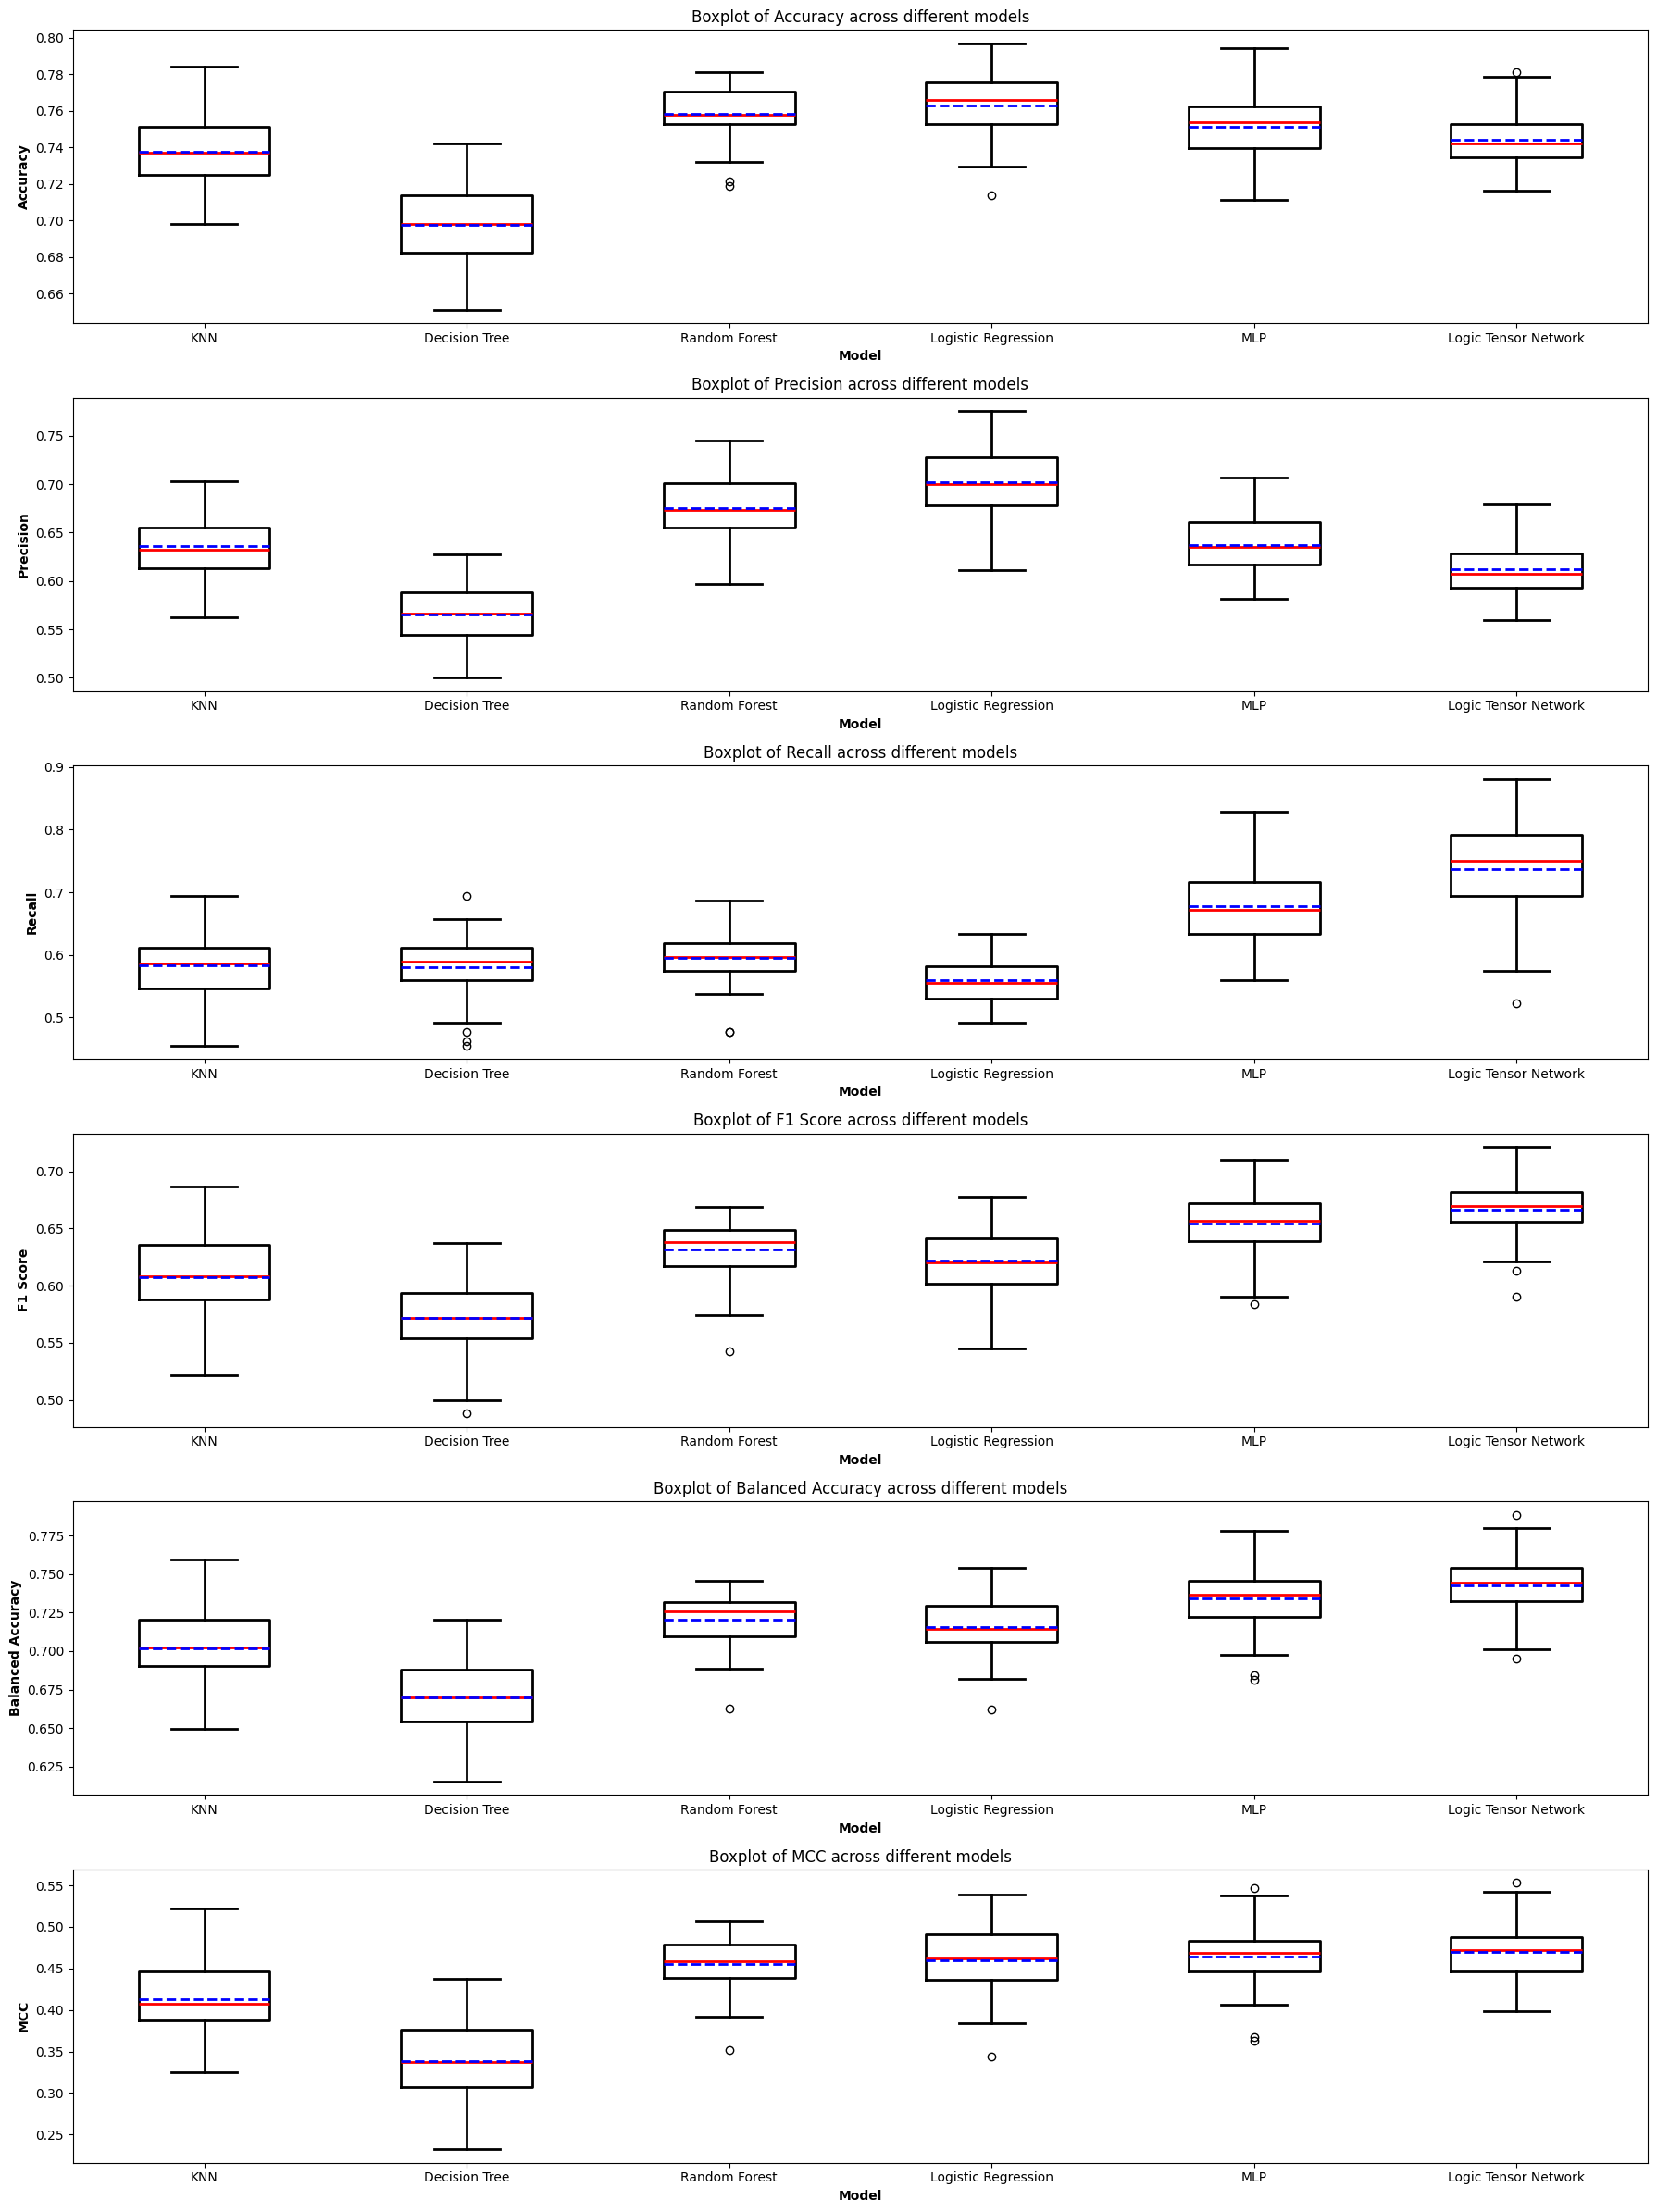

In [38]:
plot_metrics(metrics_df, metrics)

In [39]:
compare_models(metrics_df)


Accuracy:
  Logistic Regression is significantly better than KNN (adjusted p = 0.0000)
  Logistic Regression is significantly better than Decision Tree (adjusted p = 0.0000)
  Logistic Regression is NOT significantly better than Random Forest (adjusted p = 0.2299)
  Logistic Regression is significantly better than MLP (adjusted p = 0.0006)
  Logistic Regression is significantly better than Logic Tensor Network (adjusted p = 0.0000)

Precision:
  Logistic Regression is significantly better than KNN (adjusted p = 0.0000)
  Logistic Regression is significantly better than Decision Tree (adjusted p = 0.0000)
  Logistic Regression is significantly better than Random Forest (adjusted p = 0.0000)
  Logistic Regression is significantly better than MLP (adjusted p = 0.0000)
  Logistic Regression is significantly better than Logic Tensor Network (adjusted p = 0.0000)

Recall:
  Logic Tensor Network is significantly better than KNN (adjusted p = 0.0000)
  Logic Tensor Network is significantly be

In [21]:
for model in metrics_df.index:
    perform_t_tests(metrics_df, model)
    print()
    print( "-" * 100)


Accuracy:
  There is no significant difference between Logic Tensor Network and KNN (adjusted p = 5.0000)

Precision:
  There is no significant difference between Logic Tensor Network and KNN (adjusted p = 5.0000)

Recall:
  There is no significant difference between Logic Tensor Network and KNN (adjusted p = 2.5000)

F1 Score:
  There is no significant difference between Logic Tensor Network and KNN (adjusted p = 2.5000)

Balanced Accuracy:
  There is no significant difference between Logic Tensor Network and KNN (adjusted p = 2.5000)

MCC:
  There is no significant difference between Logic Tensor Network and KNN (adjusted p = 2.5000)

----------------------------------------------------------------------------------------------------

Accuracy:
  There is no significant difference between Logic Tensor Network and Decision Tree (adjusted p = 2.5000)

Precision:
  There is no significant difference between Logic Tensor Network and Decision Tree (adjusted p = 5.0000)

Recall:
  There i

In [40]:
mean_df = pd.DataFrame(columns=metrics, index=model_names)
std_df = pd.DataFrame(columns=metrics, index=model_names)

for metric in metrics_df.columns:
    mean_df[metric] = metrics_df[metric].apply(np.mean)
    std_df[metric] = metrics_df[metric].apply(np.std)

In [41]:
mean_df.round(2)

,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,MCC
KNN,0.74,0.64,0.58,0.61,0.70,0.41
Decision Tree,0.70,0.57,0.58,0.57,0.67,0.34
Random Forest,0.76,0.68,0.59,0.63,0.72,0.46
Logistic Regression,0.76,0.70,0.56,0.62,0.72,0.46
MLP,0.75,0.64,0.68,0.65,0.73,0.46
Logic Tensor Network,0.74,0.61,0.74,0.67,0.74,0.47


In [42]:
std_df

,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,MCC
KNN,0.019538,0.032458,0.048380,0.033754,0.023426,0.045066
Decision Tree,0.021182,0.030152,0.050067,0.034394,0.024630,0.047286
Random Forest,0.014792,0.030525,0.039721,0.025281,0.017106,0.033227
Logistic Regression,0.016333,0.036730,0.037099,0.026900,0.018126,0.037510
MLP,0.017079,0.032032,0.063721,0.027631,0.020579,0.036881
Logic Tensor Network,0.014763,0.026471,0.069522,0.025823,0.019779,0.033303


# Logic Adherence

## Model Evaluation with 50 Random States

This section evaluates all models across 50 different random states in Logic adherence ( meaning how well aligned are the predictions with the given logic rules ). The following steps are performed:

 ### 1. Box Plot Visualization:  
   Box plots are generated for the evaluation metrics, allowing a clear visual comparison of model performance.
   
   

 ### 2. T-Test Comparisons:  
   Two sets of T-tests are conducted:
   
   - **Best Model Significance Test**:  
     For each rule, the T-test checks if the best-performing model is significantly better than the others.
   
   - **Comparison with Our Model**:  
     For cases where our model is not the best, it is compared against each of the other models for each rule.

### 3. Rules:

  Rule 1: forall person. (((person[BMI] > 29) and (person[Glucose] > 125 )) -> Diabetic(person))"
  
  Rule 2: forall person. (((person[BMI] < 26) and (person[Glucose] < 101 )) -> not Diabetic(person))"



In [43]:
adherence_df.index = model_names

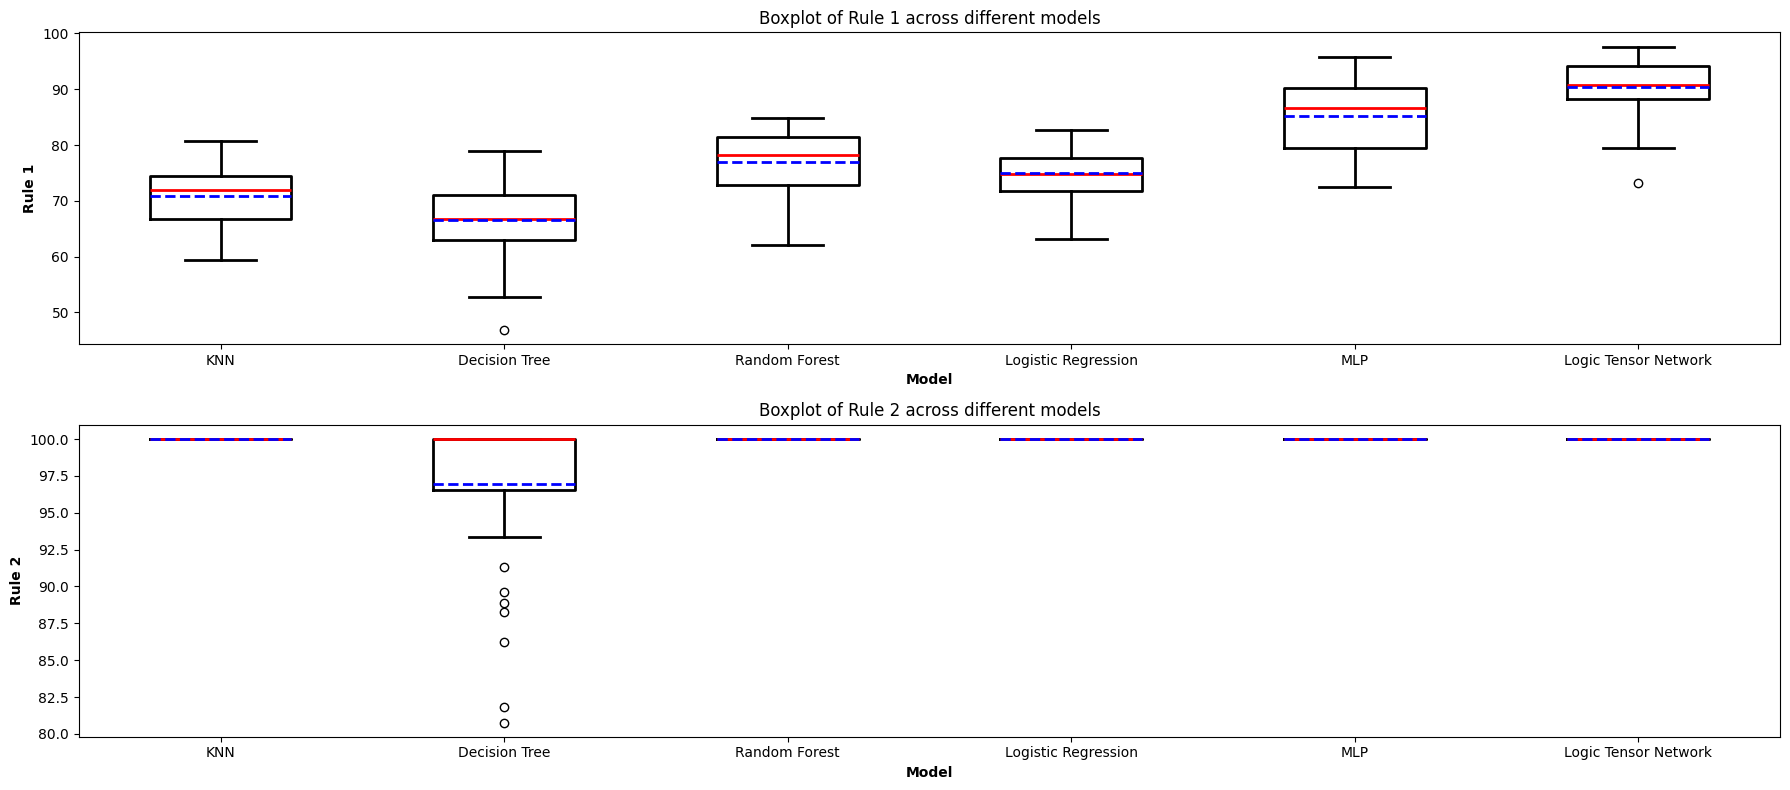

In [44]:
plot_metrics( adherence_df, ["Rule " + str(i) for i in range(1, 3)])

In [45]:
compare_models(adherence_df)

Could not perform Wilcoxon test between KNN and Random Forest for metric Rule 2
Could not perform Wilcoxon test between KNN and Logistic Regression for metric Rule 2
Could not perform Wilcoxon test between KNN and MLP for metric Rule 2
Could not perform Wilcoxon test between KNN and Logic Tensor Network for metric Rule 2

Rule 1:
  Logic Tensor Network is significantly better than KNN (adjusted p = 0.0000)
  Logic Tensor Network is significantly better than Decision Tree (adjusted p = 0.0000)
  Logic Tensor Network is significantly better than Random Forest (adjusted p = 0.0000)
  Logic Tensor Network is significantly better than Logistic Regression (adjusted p = 0.0000)
  Logic Tensor Network is significantly better than MLP (adjusted p = 0.0000)

Rule 2:
  KNN is significantly better than Decision Tree (adjusted p = 0.0001)


In [46]:
for model in metrics_df.index:
    perform_t_tests(adherence_df, model)
    print()
    print( "-" * 100)

Could not perform Wilcoxon test between Logic Tensor Network and KNN for metric Rule 2

Rule 1:
  Logic Tensor Network is significantly better than KNN (adjusted p = 0.0000)

----------------------------------------------------------------------------------------------------

Rule 1:
  Logic Tensor Network is significantly better than Decision Tree (adjusted p = 0.0000)

Rule 2:
  Logic Tensor Network is significantly better than Decision Tree (adjusted p = 0.0000)

----------------------------------------------------------------------------------------------------
Could not perform Wilcoxon test between Logic Tensor Network and Random Forest for metric Rule 2

Rule 1:
  Logic Tensor Network is significantly better than Random Forest (adjusted p = 0.0000)

----------------------------------------------------------------------------------------------------
Could not perform Wilcoxon test between Logic Tensor Network and Logistic Regression for metric Rule 2

Rule 1:
  Logic Tensor Netwo

In [47]:
mean_df = pd.DataFrame(columns=["Rule 1", "Rule 2"], index=model_names)
std_df = pd.DataFrame(columns=["Rule 1", "Rule 2"], index=model_names)

for metric in adherence_df.columns:
    mean_df[metric] = adherence_df[metric].apply(np.mean)
    std_df[metric] = adherence_df[metric].apply(np.std)

In [48]:
mean_df.round(1)

,Rule 1,Rule 2
KNN,70.8,100.0
Decision Tree,66.5,97.0
Random Forest,76.9,100.0
Logistic Regression,75.0,100.0
MLP,85.2,100.0
Logic Tensor Network,90.5,100.0


In [49]:
std_df.round(1)

,Rule 1,Rule 2
KNN,4.8,0.0
Decision Tree,6.3,4.8
Random Forest,5.4,0.0
Logistic Regression,4.2,0.0
MLP,6.2,0.0
Logic Tensor Network,5.2,0.0


# QoS

## Robustness

In [32]:
num_seeds = 20

In [33]:
from examples.medical.diabetes import roboustness

import seaborn as sns
import matplotlib.pyplot as plt

def plot_combined_robustness_metrics(noise_df, drop_df, flip_df, model_names, metrics, 
                                     x_values_list, x_labels, figsize=(26, 16)):
    sns.set_theme(style="whitegrid")  # Apply a seaborn white grid theme for better aesthetics
    num_rows = len(metrics)
    num_cols = 3  # Three types: noise, drop, flip

    # Define markers and use seaborn's color palette for colors
    markers = ['o', 's', '^', 'D', 'x', 'v', '>', '<', 'p'][:len(model_names)]
    palette = sns.color_palette("tab10", len(model_names))  # Use 'tab10' palette for better color distinction

    # Create the main figure and subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(figsize[0], figsize[1]), sharey=False)

    # Iterate through each metric and plot for noise, drop, and flip
    for row_idx, metric in enumerate(metrics):
        for col_idx, (df, x_values, x_label) in enumerate(zip([noise_df, drop_df, flip_df], x_values_list, x_labels)):
            ax = axes[row_idx, col_idx]

            # Plot each model's values for the current metric
            for model_idx, model_name in enumerate(model_names):
                ax.plot(x_values, df[metric][model_name], label=model_name, 
                        marker=markers[model_idx], color=palette[model_idx], markersize=10, linewidth=2.5)

            # Set titles, labels, and grid
            if row_idx == 0:
                ax.set_title(f"{['Noise Injection', 'Data Dropping', 'Label Flipping'][col_idx]}", fontsize=22, fontweight='bold')
            if row_idx == num_rows - 1:
                ax.set_xlabel(x_label, fontsize=18, fontweight='bold')

            # Set y-axis label to the metric name in bold
            if col_idx == 0:
                ax.set_ylabel(metric, fontsize=18, fontweight='bold')

            ax.set_xticks(x_values)  # Ensure correct x-ticks are set based on actual x-values
            ax.set_xticklabels(ax.get_xticks(), fontweight='bold')  # Make x-axis values bold
            ax.tick_params(axis='both', labelsize=14)
            ax.grid(True, linestyle='--', alpha=0.5)
            
            # Set individual y-axis limits
            ax.set_ylim(df[metric].min().min() - 0.05, df[metric].max().max() + 0.05)

    # Adjust the legend to be outside the plot with improved styling
    handles, labels = ax.get_legend_handles_labels()
    legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=len(model_names), 
                        fontsize=17, frameon=True, title="Models", title_fontsize=18, labelspacing=1.0, fancybox=True)

    # Make the legend labels and title bold
    for text in legend.get_texts():
        text.set_fontweight('bold')
    legend.get_title().set_fontweight('bold')

    # Make the legend labels bold
    for text in legend.get_texts():
        text.set_fontweight('bold')

    plt.tight_layout(rect=[0, 0, 1, 0.95], h_pad=3)  # Adjust layout with more space between subplots and adjust top space
    plt.subplots_adjust(top=0.9)  # Adjust space between legend and plots
    plt.show()



In [34]:
noise_values = np.arange(0.1, 1.1, 0.1)
seeds = range(num_seeds)

# Initialize a dictionary to store DataFrames for each metric
noise_results_df = {metric: pd.DataFrame(index=noise_values, columns=model_names) for metric in metrics}

# Loop through each noise intensity value
for noise in noise_values:
    
    print()
    print(f"Evaluating for noise intensity: {noise:.2f}")

    # Store metric results for all seeds
    seed_metrics = {model_name: {metric: [] for metric in metrics} for model_name in model_names}

    # Loop through each seed
    for seed in seeds:
        # Split the dataset into train and test sets
        train, test = prepare_datasets(data, seed)

        # Apply noise perturbation to the training set
        perturbed_train = roboustness.apply_noise(train,sigma=noise, seed=seed)
        perturbed_train.to_csv("datasets/train.csv", index=False)
        kl = roboustness.compute_kl_divergence(train, perturbed_train, train.columns[:-1])
        print(f"KL Divergence: {kl:.2f}")

        # Train and evaluate each model
        for i, model in enumerate(models):
            model_name = model_names[i]
            
            if not hasattr(model, "fit"):  
                kb = KnowledgeBase("config.yaml")            
                model = kb.predicates["Diabetic"]
                train_model(model, kb)
                freeze_model(model.model)

                # Evaluate the model on the original test set and collect all metrics
                metrics_values = evaluate_model(kb.test_loaders[0], model, kb.device)
                for metric, value in zip(metrics, metrics_values):
                    seed_metrics["MLP"][metric].append(value)

                kb.optimize(num_epochs=200, lr=0.000001, early_stopping=True, verbose=False)
                metrics_values = evaluate_model(kb.test_loaders[0], kb.predicates["Diabetic"], kb.device)
                for metric, value in zip(metrics, metrics_values):
                    seed_metrics["Logic Tensor Network"][metric].append(value)
                
            else:  
                model.fit(perturbed_train.drop('Outcome', axis=1), perturbed_train['Outcome'])
                metrics_values = evaluate_sklearn_model(test, model)  # Collect all metrics from sklearn evaluation
                for metric, value in zip(metrics, metrics_values):
                    seed_metrics[model_name][metric].append(value)

    for model_name in model_names:
        for metric in metrics:
            noise_results_df[metric].loc[noise, model_name] = np.mean(seed_metrics[model_name][metric])


Evaluating for noise intensity: 0.10
KL Divergence: 0.27
Using device: cpu
KL Divergence: 0.34
Using device: cpu
KL Divergence: 0.37
Using device: cpu
KL Divergence: 0.25
Using device: cpu
KL Divergence: 0.26
Using device: cpu
KL Divergence: 0.30
Using device: cpu
KL Divergence: 0.27
Using device: cpu
KL Divergence: 0.42
Using device: cpu
KL Divergence: 0.34
Using device: cpu
KL Divergence: 0.39
Using device: cpu
KL Divergence: 0.32
Using device: cpu
KL Divergence: 0.25
Using device: cpu
KL Divergence: 0.26
Using device: cpu
KL Divergence: 0.27
Using device: cpu
KL Divergence: 0.30
Using device: cpu
KL Divergence: 0.35
Using device: cpu
KL Divergence: 0.33
Using device: cpu
KL Divergence: 0.30
Using device: cpu
KL Divergence: 0.31
Using device: cpu
KL Divergence: 0.36
Using device: cpu

Evaluating for noise intensity: 0.20
KL Divergence: 1.24
Using device: cpu
KL Divergence: 1.38
Using device: cpu
KL Divergence: 1.47
Using device: cpu
KL Divergence: 1.19
Using device: cpu
KL Divergenc

KeyboardInterrupt: 

In [ ]:
drop_rates = np.arange(0.0, 1.0, 0.05)
seeds = range(num_seeds)

# Initialize a dictionary to store DataFrames for each metric
drop_results_df = {metric: pd.DataFrame(index=drop_rates, columns=model_names) for metric in metrics}

# Loop through each drop rate value
for drop_rate in drop_rates:
    
    print(f"\nEvaluating for data dropping rate: {drop_rate:.2f}")

    # Store metric results for all seeds
    seed_metrics = {model_name: {metric: [] for metric in metrics} for model_name in model_names}

    # Loop through each seed
    for seed in seeds:
        # Split the dataset into train and test sets
        train, test = prepare_datasets(data, seed)

        # Apply data dropping to the training set using the provided method
        perturbed_train = roboustness.apply_data_dropping(train, drop_prob=drop_rate, seed=seed, label_column='Outcome')
        perturbed_train.to_csv("datasets/train.csv", index=False)
        
        # Compute KL Divergence if there are still rows remaining
        if len(perturbed_train) > 0:
            kl = roboustness.compute_kl_divergence(train, perturbed_train, train.columns[:-1])
            print(f"Number of rows remaining: {len(perturbed_train)}")
        
        # Train and evaluate each model
        for i, model in enumerate(models):
            model_name = model_names[i]

            try:
                if not hasattr(model, "fit"):  
                    kb = KnowledgeBase("config.yaml")            
                    model = kb.predicates["Diabetic"]
                    train_model(model, kb)
                    freeze_model(model.model)

                    # Evaluate the model on the original test set and collect all metrics
                    metrics_values = evaluate_model(kb.test_loaders[0], model, kb.device)
                    for metric, value in zip(metrics, metrics_values):
                        seed_metrics["MLP"][metric].append(value)

                    kb.optimize(num_epochs=200, lr=0.000001, early_stopping=True, verbose=False)
                    metrics_values = evaluate_model(kb.test_loaders[0], kb.predicates["Diabetic"], kb.device)
                    for metric, value in zip(metrics, metrics_values):
                        seed_metrics["Logic Tensor Network"][metric].append(value)
                    
                else:  
                    model.fit(perturbed_train.drop('Outcome', axis=1), perturbed_train['Outcome'])
                    metrics_values = evaluate_sklearn_model(test, model)  # Collect all metrics from sklearn evaluation
                    for metric, value in zip(metrics, metrics_values):
                        seed_metrics[model_name][metric].append(value)
            except:
                print("Skipping seed batch size issue")

    # Store the mean metrics for the current drop rate
    for model_name in model_names:
        for metric in metrics:
            drop_results_df[metric].loc[drop_rate, model_name] = np.mean(seed_metrics[model_name][metric])


In [ ]:
flip_rates = np.arange(0.0, 1.0, 0.1)
seeds = range(num_seeds)

# Initialize a dictionary to store DataFrames for each metric
flip_results_df = {metric: pd.DataFrame(index=flip_rates, columns=model_names) for metric in metrics}

# Loop through each flip rate value
for flip_rate in flip_rates:
    
    print(f"\nEvaluating for label flipping rate: {flip_rate:.2f}")

    # Store metric results for all seeds
    seed_metrics = {model_name: {metric: [] for metric in metrics} for model_name in model_names}

    # Loop through each seed
    for seed in seeds:
        # Split the dataset into train and test sets
        train, test = prepare_datasets(data, seed)

        # Apply label flipping to the training set
        perturbed_train = roboustness.flip_labels_general(train, label_column='Outcome', flip_prob=flip_rate, seed=seed)
        perturbed_train.to_csv("datasets/train.csv", index=False)
        
        # Train and evaluate each model
        for i, model in enumerate(models):
            model_name = model_names[i]
            
            if not hasattr(model, "fit"):  
                kb = KnowledgeBase("config.yaml")            
                model = kb.predicates["Diabetic"]
                train_model(model, kb)
                freeze_model(model.model)

                # Evaluate the model on the original test set and collect all metrics
                metrics_values = evaluate_model(kb.test_loaders[0], model, kb.device)
                for metric, value in zip(metrics, metrics_values):
                    seed_metrics["MLP"][metric].append(value)

                kb.optimize(num_epochs=200, lr=0.000001, early_stopping=True, verbose=False)
                metrics_values = evaluate_model(kb.test_loaders[0], kb.predicates["Diabetic"], kb.device)
                for metric, value in zip(metrics, metrics_values):
                    seed_metrics["Logic Tensor Network"][metric].append(value)
                
            else:  
                model.fit(perturbed_train.drop('Outcome', axis=1), perturbed_train['Outcome'])
                metrics_values = evaluate_sklearn_model(test, model)  # Collect all metrics from sklearn evaluation
                for metric, value in zip(metrics, metrics_values):
                    seed_metrics[model_name][metric].append(value)

    # Store the mean metrics for the current flip rate
    for model_name in model_names:
        for metric in metrics:
            flip_results_df[metric].loc[flip_rate, model_name] = np.mean(seed_metrics[model_name][metric])


In [37]:
import pickle

with open('noise_results_df.pkl', 'wb') as f:
    pickle.dump(noise_results_df, f)

# Save the drop_results_df to a pickle file
with open('drop_results_df.pkl', 'wb') as f:
    pickle.dump(drop_results_df, f)
    
# Save the flip_results_df to a pickle file
with open('flip_results_df.pkl', 'wb') as f:
    pickle.dump(flip_results_df, f)

In [47]:
with open('results/noise_results_df.pkl', 'rb') as f:
    noise_results_df = pickle.load(f)

with open('results/drop_results_df.pkl', 'rb') as f:
    drop_results_df = pickle.load(f)

with open('results/flip_results_df.pkl', 'rb') as f:
    flip_results_df = pickle.load(f)

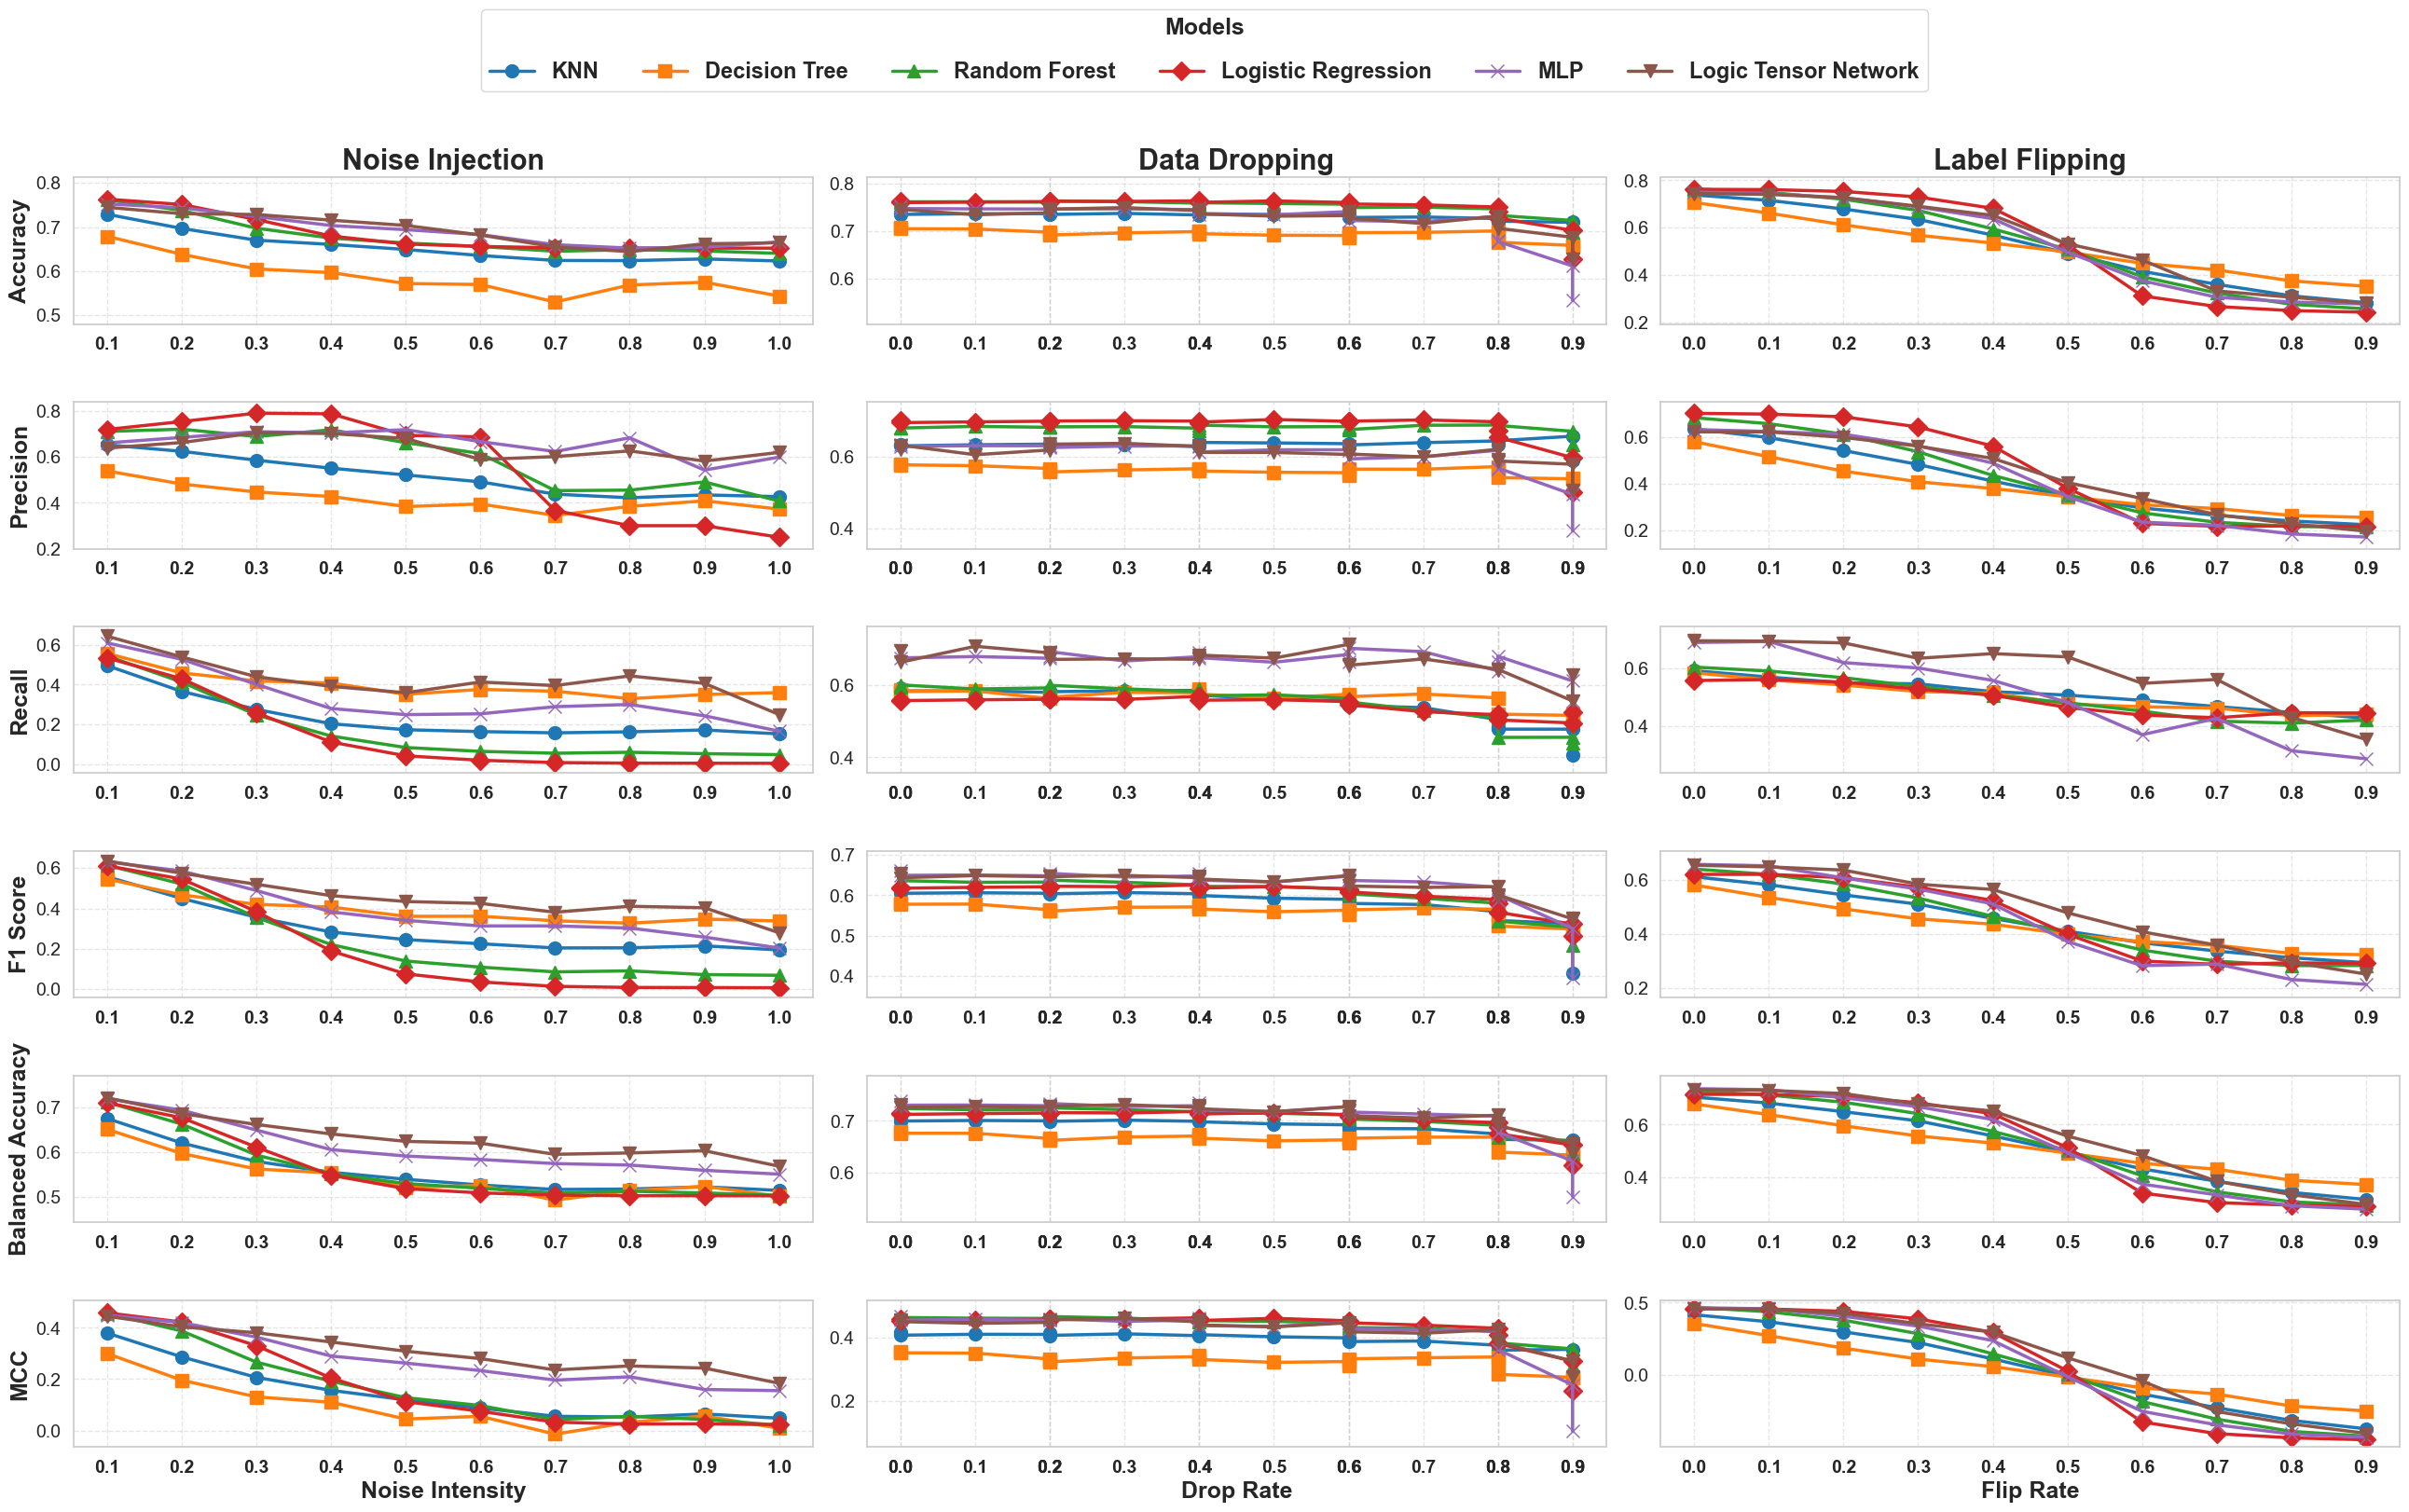

In [92]:
noise_values = np.arange(0.1, 1.1, 0.1).round(1)
drop_rates = (np.arange(0.0, 1, 0.05)).round(1)
flip_rates = np.arange(0.0, 1.0, 0.1).round(1)
drop_rates[-1] = 0.9

plot_combined_robustness_metrics(noise_results_df, drop_results_df, flip_results_df, 
                                          model_names, metrics, 
                                          x_values_list=[noise_values, drop_rates, flip_rates], 
                                          x_labels=["Noise Intensity", "Drop Rate", "Flip Rate"])

## Data Efficiency 

In [40]:
num_seeds = 20

In [117]:
def plot_data_efficiency(data_efficiency_df, model_names, metrics, training_sizes, figsize=(8, 14)):
    sns.set_theme(style="whitegrid")  # Apply a seaborn white grid theme for better aesthetics
    num_metrics = len(metrics)

    # Define markers and colors using a seaborn color palette
    markers = ['o', 's', '^', 'D', 'x', 'v', '>', '<', 'p'][:len(model_names)]
    palette = sns.color_palette("tab10", len(model_names))  # Changed to 'tab10' palette for better distinction

    # Create the main figure and subplots
    fig, axes = plt.subplots(num_metrics, 1, figsize=(figsize[0], figsize[1]), sharex=False)

    # Iterate through each metric
    for idx, metric in enumerate(metrics):
        ax = axes[idx]

        # Plot each model's values for the current metric over training sizes
        for model_idx, model_name in enumerate(model_names):
            ax.plot(training_sizes, data_efficiency_df[metric][model_name], label=model_name, 
                    marker=markers[model_idx], color=palette[model_idx], markersize=9, linewidth=2)

        # Set labels, grid, and adjust for bold metric labels
        ax.set_ylabel(metric, fontsize=16, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xticks(training_sizes)  # Ensure correct x-ticks are set based on actual training sizes
        ax.set_xticklabels([f"{x:.1f}" for x in training_sizes], fontsize=14, fontweight='bold')  # Make x-ticks bold and rounded
        ax.tick_params(axis='both', labelsize=14)

    # Set x-label only on the last subplot
    axes[-1].set_xlabel("Training Size", fontsize=16, fontweight='bold')

    # Adjust the legend to be outside the plot with improved styling
    handles, labels = ax.get_legend_handles_labels()
    legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), 
                        ncol=(len(model_names) // 2) + (len(model_names) % 2),  # Adjust ncol for 2 rows
                        fontsize=16, frameon=True, title="Models", title_fontsize=18, labelspacing=0.8, fancybox=True)


    # Make the legend labels and title bold
    for text in legend.get_texts():
        text.set_fontweight('bold')
    legend.get_title().set_fontweight('bold')
    
    # Make the legend labels bold
    for text in legend.get_texts():
        text.set_fontweight('bold')

    

    plt.tight_layout(rect=[0, 0, 1, 0.95], h_pad=2)  # Adjust layout with more space between subplots and adjust top space
    plt.subplots_adjust(top=0.88)  # Adjust space between legend and plots
    plt.show()


<!--  -->

In [ ]:
# Define the different training sizes from 10% to 100% with 10% intervals
training_sizes = np.arange(0.1, 1.1, 0.1)
seeds = range(num_seeds)

# Initialize a dictionary to store DataFrames for each metric
data_efficiency_df = {metric: pd.DataFrame(index=training_sizes, columns=model_names) for metric in metrics}

# Loop through each training size values
for train_size in training_sizes:
    
    print(f"\nEvaluating for training size: {train_size:.2f}")

    # Store metric results for all seeds
    seed_metrics = {model_name: {metric: [] for metric in metrics} for model_name in model_names}

    # Loop through each seed
    for seed in seeds:
        # Split the dataset into train and test sets
        train, test = prepare_datasets(data, seed)
        
        # Sample a fraction of the training set based on the current training size
        sampled_train = train.sample(frac=train_size, random_state=seed)
        sampled_train.to_csv("datasets/train.csv", index=False)
        
        # Split into features and labels
        X_train = sampled_train.drop('Outcome', axis=1)
        y_train = sampled_train['Outcome']
        
        X_test = test.drop('Outcome', axis=1)
        y_test = test['Outcome']
        
        # Train and evaluate each model
        for i, model in enumerate(models):
            model_name = model_names[i]
            
            if not hasattr(model, "fit"):  # Handle PyTorch model training
                kb = KnowledgeBase("config.yaml")            
                model = kb.predicates["Diabetic"]
                train_model(model, kb)
                freeze_model(model.model)

                # Evaluate the model on the test set and collect all metrics
                metrics_values = evaluate_model(kb.test_loaders[0], model, kb.device)
                for metric, value in zip(metrics, metrics_values):
                    seed_metrics["MLP"][metric].append(value)

                # Optimizing the model
                kb.optimize(num_epochs=200, lr=0.000001, early_stopping=True, verbose=False)
                metrics_values = evaluate_model(kb.test_loaders[0], kb.predicates["Diabetic"], kb.device)
                for metric, value in zip(metrics, metrics_values):
                    seed_metrics["Logic Tensor Network"][metric].append(value)
                
            else:  # Handle sklearn model training
                model.fit(X_train, y_train)
                metrics_values = evaluate_sklearn_model(test, model)  # Collect all metrics from sklearn evaluation
                for metric, value in zip(metrics, metrics_values):
                    seed_metrics[model_name][metric].append(value)

    # Store the mean metrics for the current training size
    for model_name in model_names:
        for metric in metrics:
            data_efficiency_df[metric].loc[train_size, model_name] = np.mean(seed_metrics[model_name][metric])

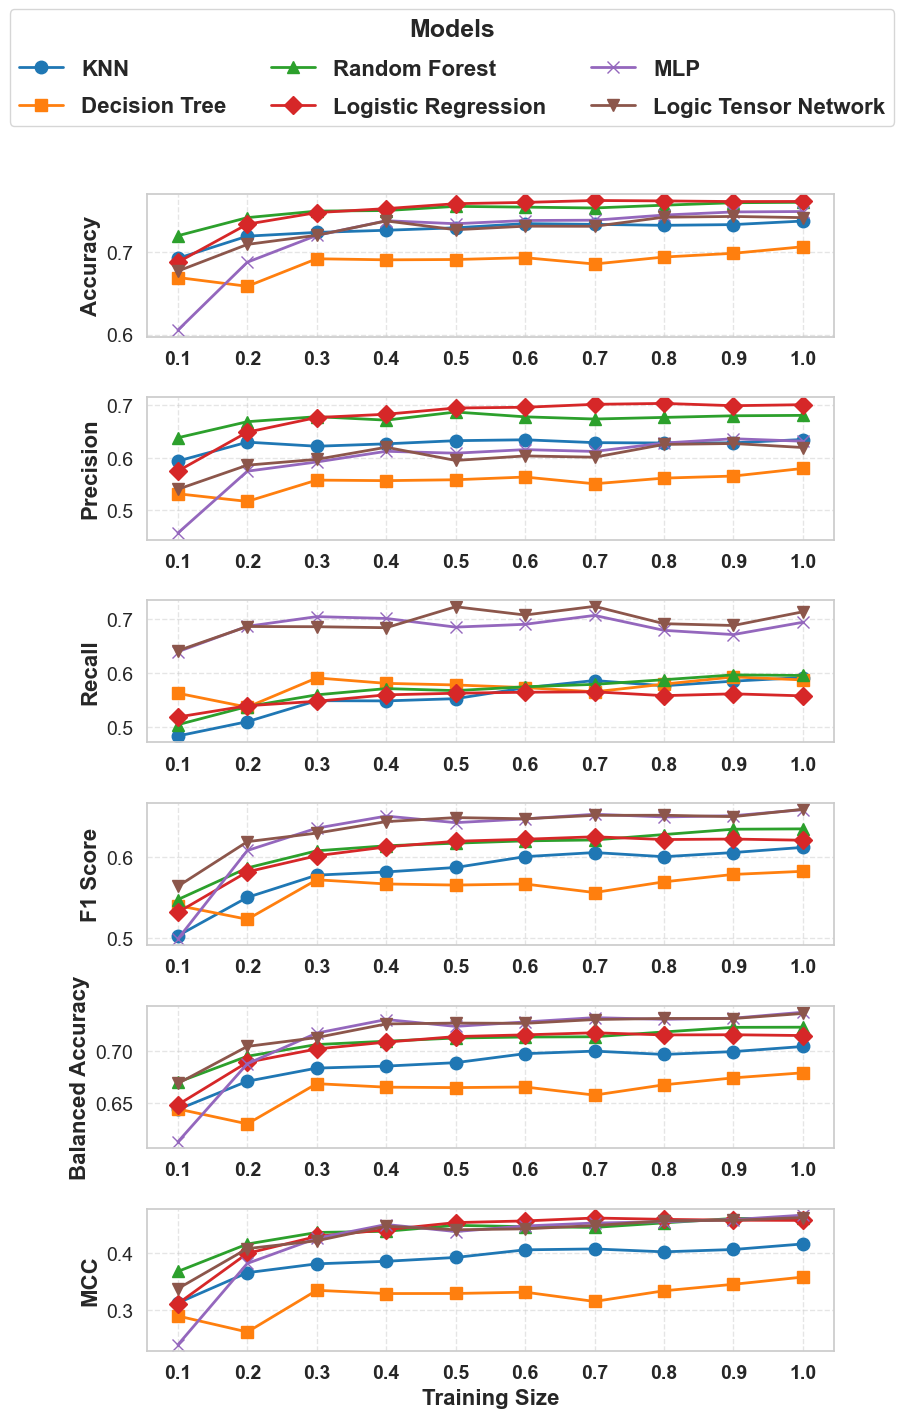

In [118]:
plot_data_efficiency(data_efficiency_df, model_names, metrics, training_sizes)

In [44]:
with open('data_efficiency_df.pkl', 'wb') as f:
    pickle.dump(data_efficiency_df, f)